In [1]:
import pandas as pd # 引用套件並縮寫為 pd  
df_capterra = pd.read_csv('MicrosoftTeams.csv', encoding='utf_8_sig', index_col=0) 
df_capterra

,Title,Overall,Pros,Cons,Switch,Switch_reason,Alter,Alter_reason
Review,,,,,,,,
1,“Microsoft Teams is a game changer in a pandem...,Live Chat in Microsoft Teams is the very reaso...,"Just as things became difficult with COVID-19,...",I believe the only downfall is that integratio...,NaN,NaN,Zoom Meetings,Live Chat in Microsoft Teams is the very reaso...
2,“Just what we need to stay connected”,NaN,I know there are other chat features out there...,"I'm sure it's gotten better now, but the video...",NaN,NaN,Google Chat,We already had it as a part of Microsoft 365 s...
3,“Microsoft Teams Collaboration Platform”,Microsoft Teams is a very powerful tool that g...,Integration is one of the most remarcable feat...,External collaborators are not familiar with i...,Zoom Meetings,Intregration to Office365 and other products s...,"Webex, Zoom Meetings and GoToMeeting",The level of integration with other Microsoft ...
4,“Probably switching to Slack and Zoom”,Microsoft Teams does a good job. I don't want...,It's handy to have a software that is connecte...,"It's not as widely adopted as Zoom, and so I f...",Zoom Meetings and GoToMeeting,Primarily because of security concerns with Zoom.,Zoom Meetings and GoToMeeting,They had the best combination of security and ...
5,"“A decent alternative for work messages, but n...",My experience with Microsoft Teams has been mi...,The strongest point of Microsoft Teams is the ...,The interface is not pleasant. Adding documen...,Slack,It was requested by the company to switch to M...,NaN,NaN
...,...,...,...,...,...,...,...,...
2996,“Microsoft Teams Review”,NaN,The user-friendly and ease of access. Addition...,The only cons that I could mention is that whe...,NaN,NaN,NaN,NaN
2997,“Mostly Like”,My company previously used Skype for Business ...,"So easy to instant message, I love the gif/mem...",The only issue I have with Teams is using it f...,NaN,NaN,NaN,NaN
2998,“Microsoft Teams review”,Good,Allows for easy interfacing with patients. Sen...,Sometimes can be difficult for users to connec...,NaN,NaN,NaN,NaN


In [2]:
doc_complete = df_capterra.Cons.values.tolist()
doc_complete[0]

'I believe the only downfall is that integrations and file sharing could be more, just more.'

In [3]:
# Convert to list
doc_complete = df_capterra.Cons.values.tolist()
doc_seperate=[]
import re
for review in doc_complete:
    pattern = r'.'
    review = str(review)
    result = review.split('.')
    for i in result:
        doc_seperate.append(i)
doc_seperate[1]

''

In [4]:
import gensim
from gensim.utils import simple_preprocess
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(doc_seperate))
print(data_words[1])

[]


In [5]:
from gensim.models.phrases import Phrases, ENGLISH_CONNECTOR_WORDS
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['believe', 'the', 'only', 'downfall', 'is', 'that', 'integrations', 'and', 'file', 'sharing', 'could', 'be', 'more', 'just', 'more']


In [6]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['nan', 'subject', 're', 'edu'])

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [7]:
import spacy
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_trigrams = make_trigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# !python -m spacy download en

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_trigrams, allowed_postags=['NOUN'])

print(data_lemmatized[0])

['integration', 'file', 'sharing']


In [8]:
from gensim import corpora
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1)]]


### LDA 法一

In [ ]:
from gensim.models import CoherenceModel
# Build LDA model
import matplotlib.pyplot as plt
topics_num = []
Coherence_Score = []

for i in range(1,21):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=i, 
                                               random_state=100,
                                               update_every=1,
                                               chunksize=100,
                                               passes=10,
                                               alpha='auto',
                                               per_word_topics=True)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    topics_num.append(i)
    Coherence_Score.append(coherence_lda)

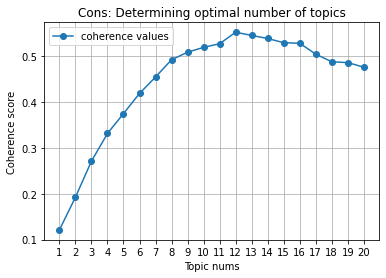

In [10]:
lines = plt.plot(topics_num, Coherence_Score)
plt.setp(lines, marker = "o") 
plt.grid(True)
plt.title("Cons: Determining optimal number of topics") 
plt.xlabel("Topic nums")
plt.ylabel("Coherence score")
plt.legend(["coherence values"], loc='best')
plt.xticks(topics_num)
plt.show()

In [9]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=12, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [10]:
from pprint import pprint
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.264*"chat" + 0.110*"organization" + 0.088*"conversation" + 0.080*"status" '
  '+ 0.042*"name" + 0.037*"find" + 0.023*"comment" + 0.021*"thread" + '
  '0.021*"box" + 0.020*"type"'),
 (1,
  '0.177*"thing" + 0.098*"application" + 0.090*"window" + 0.076*"program" + '
  '0.070*"function" + 0.045*"improvement" + 0.033*"memory" + 0.032*"web" + '
  '0.026*"download" + 0.025*"mobile"'),
 (2,
  '0.214*"notification" + 0.138*"problem" + 0.137*"platform" + '
  '0.046*"communication" + 0.036*"sound" + 0.034*"design" + 0.028*"list" + '
  '0.017*"alert" + 0.016*"authentication" + 0.015*"place"'),
 (3,
  '0.433*"team" + 0.133*"meeting" + 0.029*"functionality" + 0.027*"interface" '
  '+ 0.024*"slack" + 0.022*"day" + 0.018*"voice" + 0.014*"datum" + '
  '0.014*"audio" + 0.013*"office"'),
 (4,
  '0.203*"software" + 0.124*"screen" + 0.097*"people" + 0.085*"bit" + '
  '0.079*"work" + 0.037*"share" + 0.034*"setting" + 0.033*"search" + '
  '0.027*"need" + 0.022*"experience"'),
 (5,
  '0.445*"time" +

In [12]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.316245775405165

Coherence Score:  0.55297244791101


In [14]:
import pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.415534  0.132423       1        1  16.799874
4     -0.091676 -0.420229       2        1  12.152103
6      0.005560 -0.001786       3        1  10.228390
7      0.044065  0.027408       4        1   9.787156
11     0.036853  0.023268       5        1   9.418776
9      0.058840  0.033981       6        1   7.545774
10     0.049348  0.029835       7        1   6.977894
5      0.054927  0.032304       8        1   6.390493
1      0.061613  0.034888       9        1   6.256904
8      0.065889  0.036326      10        1   5.747913
0      0.064762  0.035694      11        1   4.607048
2      0.065351  0.035888      12        1   4.087675, topic_info=          Term         Freq        Total Category  logprob  loglift
10        team  1809.000000  1809.000000  Default  30.0000  30.0000
11        time   707.000000   707.000000  Default  29.0000  29.0000
20    software   615.000000   615.000000  Default  28.0000  28.0000
23     feature   420.000000   420.000000  Default  27.0000  27.0000
45       issue   471.000000   471.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
222  bluetooth     2.768978     3.839712  Topic12  -5.9059   2.8703
223        cut     2.335164     3.405926  Topic12  -6.0763   2.8198
727       read     1.215301     2.287329  Topic12  -6.7294   2.5648
46      corner     1.139772     2.210495  Topic12  -6.7935   2.5348
704      linux     0.631721     1.702433  Topic12  -7.3837   2.2058

[391 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
86        3  0.971869   ability
183       5  0.970397    access
386       3  0.976882   account
339       4  0.960932  activity
403      11  0.877937     admin
...     ...       ...       ...
95        2  0.995837      work
809      10  0.976514   working
287       8  0.866448     world
213       9  0.949784      year
12        3  0.989389      zoom

[357 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 7, 8, 12, 10, 11, 6, 2, 9, 1, 3])

In [11]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each review
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=doc_seperate)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Cons_review_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic

,Cons_review_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,8.0,0.2129,"sharing, company, integration, control, outloo...",I believe the only downfall is that integratio...
1,1,3.0,0.1689,"team, meeting, functionality, interface, slack...",
2,2,6.0,0.1756,"video, use, call, group, quality, zoom, confer...","I'm sure it's gotten better now, but the video..."
3,3,6.0,0.2473,"video, use, call, group, quality, zoom, confer...","At the height of the pandemic, we tried using..."
4,4,6.0,0.3849,"video, use, call, group, quality, zoom, confer...","It does have screenshare, so that's good now,..."
...,...,...,...,...,...
9471,9471,8.0,0.1535,"sharing, company, integration, control, outloo...",\n\nmight be processing power of my laptop though
9472,9472,3.0,0.2112,"team, meeting, functionality, interface, slack...",The Microsoft Teams is a bit confusing at the ...
9473,9473,10.0,0.1516,"feature, option, tool, skype, other, backgroun...","I wish they have more integration, as Microso..."
9474,9474,4.0,0.1641,"software, screen, people, bit, work, share, se...",The user experience is also not the best and ...


In [12]:
df_dominant_topic[df_dominant_topic["Dominant_Topic"] == 3.0].sort_values(by=['Topic_Perc_Contrib'], ascending=False)

,Cons_review_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
639,639,3.0,0.4747,"team, meeting, functionality, interface, slack...","It happens to me with the ""team sites"" that s..."
484,484,3.0,0.4480,"team, meeting, functionality, interface, slack...","Within the Teams application, there is a sect..."
7160,7160,3.0,0.4409,"team, meeting, functionality, interface, slack...",\r\n\r\nI find the meetings functionality a li...
485,485,3.0,0.4409,"team, meeting, functionality, interface, slack...",Communicating this to people is frustrating -...
52,52,3.0,0.4316,"team, meeting, functionality, interface, slack...",The navigation of teams gets some taking used ...
...,...,...,...,...,...
3639,3639,3.0,0.1432,"team, meeting, functionality, interface, slack...",Notifications sometimes don't notify me correc...
4282,4282,3.0,0.1395,"team, meeting, functionality, interface, slack...",Sometimes I find that the notifications are un...
4598,4598,3.0,0.1372,"team, meeting, functionality, interface, slack...",and I have yet to figure out how to unhide ch...
6600,6600,3.0,0.1372,"team, meeting, functionality, interface, slack...",It is definitely more complex to pull up a sim...


In [13]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.3696,"chat, organization, conversation, status, name...","\n\nAlso, you can search previous conversatio..."
1,1.0,0.3531,"thing, application, window, program, function,...",And the mobile application needs more optimiz...
2,2.0,0.3441,"notification, problem, platform, communication...","Maybe it's marginal, but even the list of emo..."
3,3.0,0.4747,"team, meeting, functionality, interface, slack...","It happens to me with the ""team sites"" that s..."
4,4.0,0.4448,"software, screen, people, bit, work, share, se...",Rest I love this software its make my work li...
5,5.0,0.3719,"time, product, channel, client, number, reason...",\nThis product is a 365 Microsoft suite and mi...
6,6.0,0.4006,"video, use, call, group, quality, zoom, confer...",Presentation of ppt at times get stuck in ful...
7,7.0,0.4976,"app, message, lot, version, desktop, phone, in...","When you move from one network to another, mo..."
8,8.0,0.3291,"sharing, company, integration, control, outloo...",There are some feature like calendar manageme...
9,9.0,0.4524,"file, way, document, person, change, member, t...","When you click on an attachment or photo, it..."


In [14]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)
# topic_contribution = topic_contribution.rename_axis('Dominant_Topic').reset_index(name='percentage')

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']].drop_duplicates()
topic_num_keywords.index = range(len(topic_num_keywords))

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_contribution, topic_counts], axis=1)
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Perc_eviews', 'Num_Reviews']
df_dominant_topics.sort_values(by=['Dominant_Topic'])

,Dominant_Topic,Topic_Keywords,Perc_eviews,Num_Reviews
11.0,0.0,"chat, organization, conversation, status, name...",0.0530,502
10.0,1.0,"thing, application, window, program, function,...",0.0306,290
3.0,2.0,"notification, problem, platform, communication...",0.5467,5181
1.0,3.0,"team, meeting, functionality, interface, slack...",0.0236,224
4.0,4.0,"software, screen, people, bit, work, share, se...",0.1125,1066
7.0,5.0,"time, product, channel, client, number, reason...",0.0653,619
2.0,6.0,"video, use, call, group, quality, zoom, confer...",0.0052,49
9.0,7.0,"app, message, lot, version, desktop, phone, in...",0.0392,371
0.0,8.0,"sharing, company, integration, control, outloo...",0.0058,55
6.0,9.0,"file, way, document, person, change, member, t...",0.0758,718


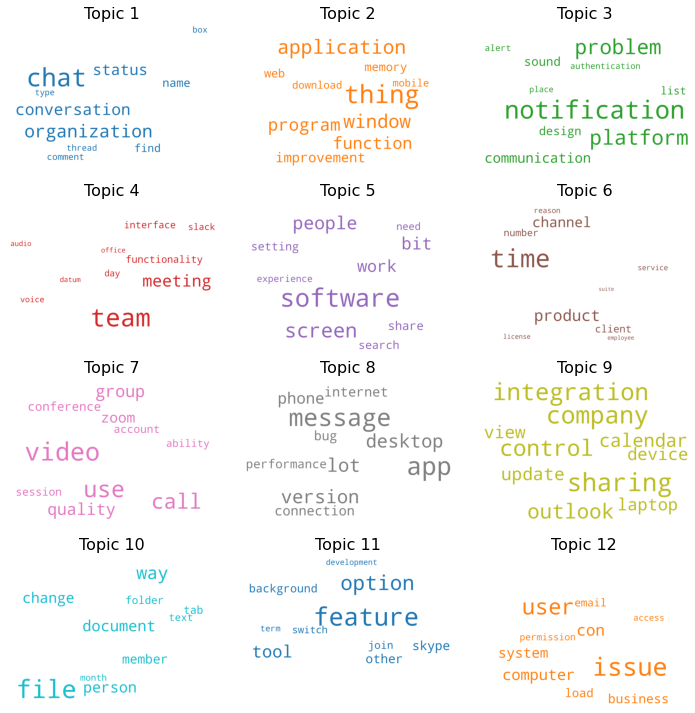

In [15]:
# 1. Wordcloud of Top N words in each topic
import numpy as np
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

color_list = [('tab:blue', '#1f77b4'), ('tab:orange', '#ff7f0e'), ('tab:green', '#2ca02c'), ('tab:red', '#d62728'), ('tab:purple', '#9467bd'), 
 ('tab:brown', '#8c564b'), ('tab:pink', '#e377c2'),  ('tab:gray', '#7f7f7f'), ('tab:olive', '#bcbd22'), ('tab:cyan', '#17becf'), 
 ('tab:blue', '#1f77b4'), ('tab:orange', '#ff7f0e'), ('tab:green', '#2ca02c'), ('tab:red', '#d62728'), ('tab:purple', '#9467bd'), 
 ('tab:brown', '#8c564b'), ('tab:pink', '#e377c2'),  ('tab:gray', '#7f7f7f'), ('tab:olive', '#bcbd22'), ('tab:cyan', '#17becf')]
# cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'
cols = [color for name, color in color_list]  # more colors: 'mcolors.XKCD_COLORS'
cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False, num_topics=12)
fig, axes = plt.subplots(4, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i+1), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.savefig('Wordcloud_teams_cons.png')

plt.show()

<ipython-input-16-b8efdd8be2fd>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
<ipython-input-16-b8efdd8be2fd>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
<ipython-input-16-b8efdd8be2fd>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
<ipython-input-16-b8efdd8be2fd>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
<ipython-input-16-b8efdd8be2fd>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation

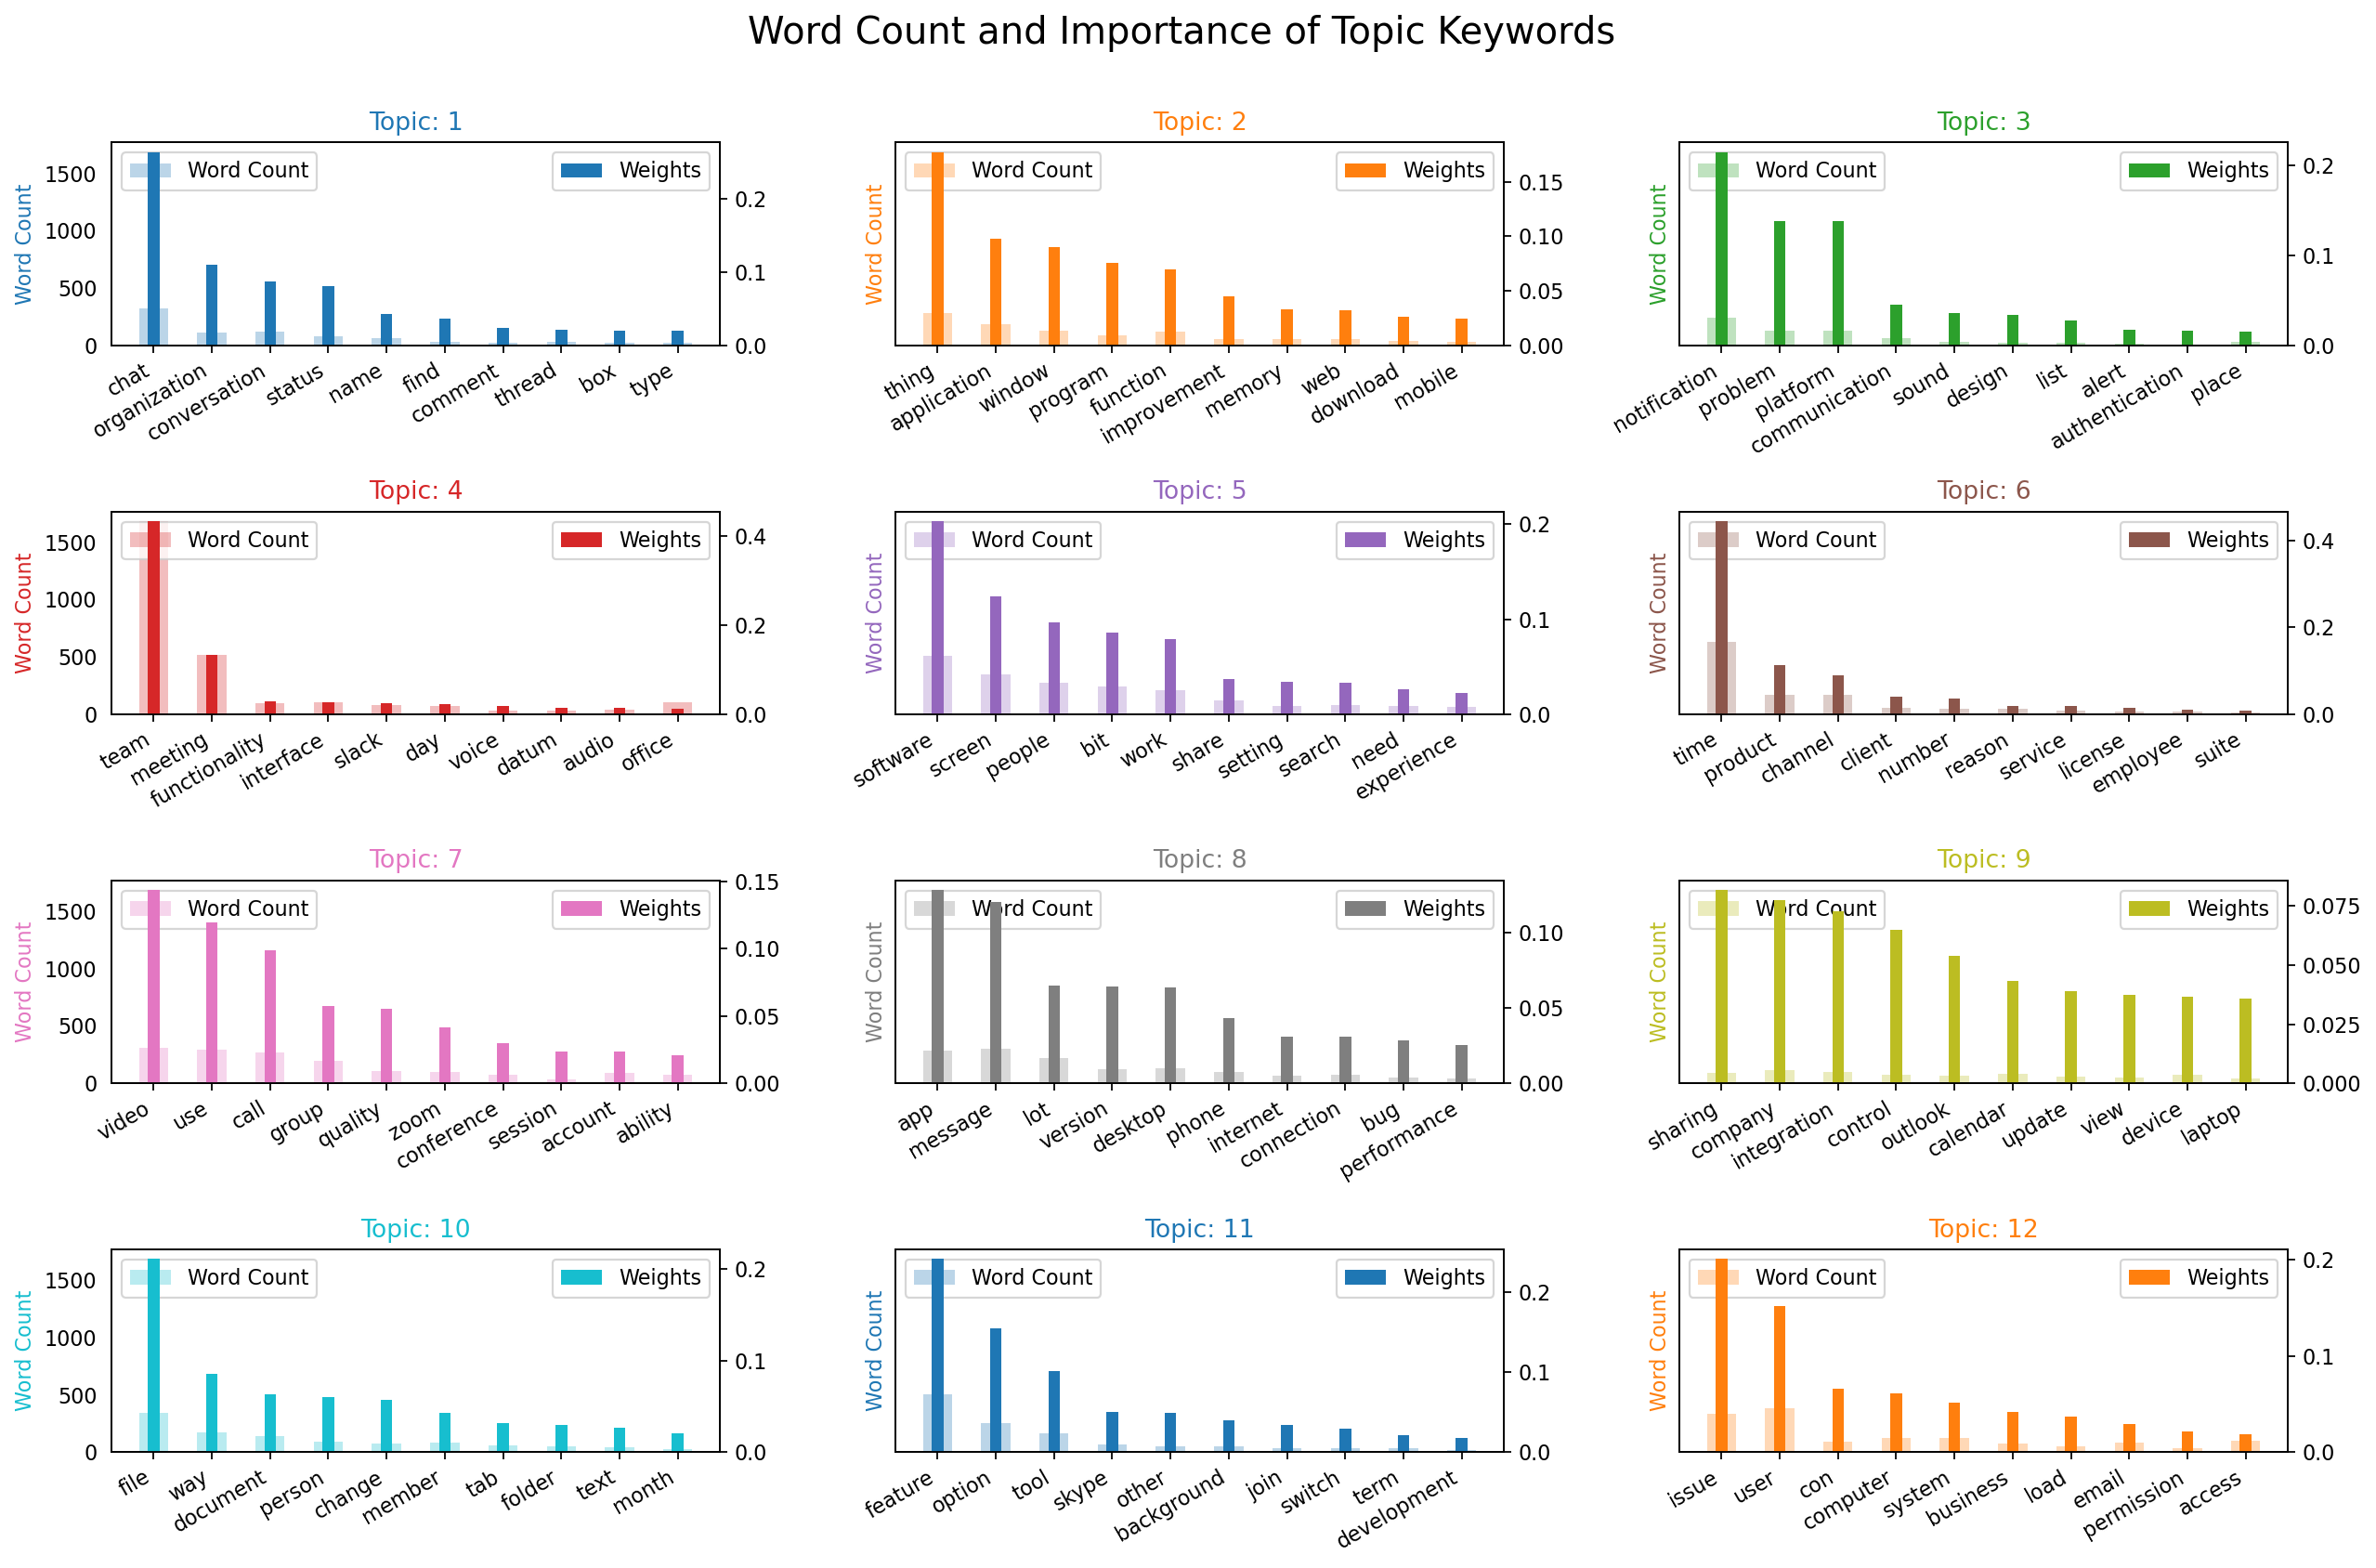

In [16]:
from collections import Counter
topics = lda_model.show_topics(formatted=False, num_topics=12)
data_flat = [w for w_list in data_lemmatized for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

df
# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(4, 3, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in color_list]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
#     ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i+1), color=cols[i], fontsize=12)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=18, y=1.05) 

plt.savefig('TopicKeywords_teams_cons.png')
plt.show()

In [16]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            
# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False, num_topics=12) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)
df_top3words

,topic_id,words
0,0,"chat, \norganization, \nconversation"
1,1,"thing, \napplication, \nwindow"
2,2,"notification, \nproblem, \nplatform"
3,3,"team, \nmeeting, \nfunctionality"
4,4,"software, \nscreen, \npeople"
5,5,"time, \nproduct, \nchannel"
6,6,"video, \nuse, \ncall"
7,7,"app, \nmessage, \nlot"
8,8,"sharing, \ncompany, \nintegration"
9,9,"file, \nway, \ndocument"


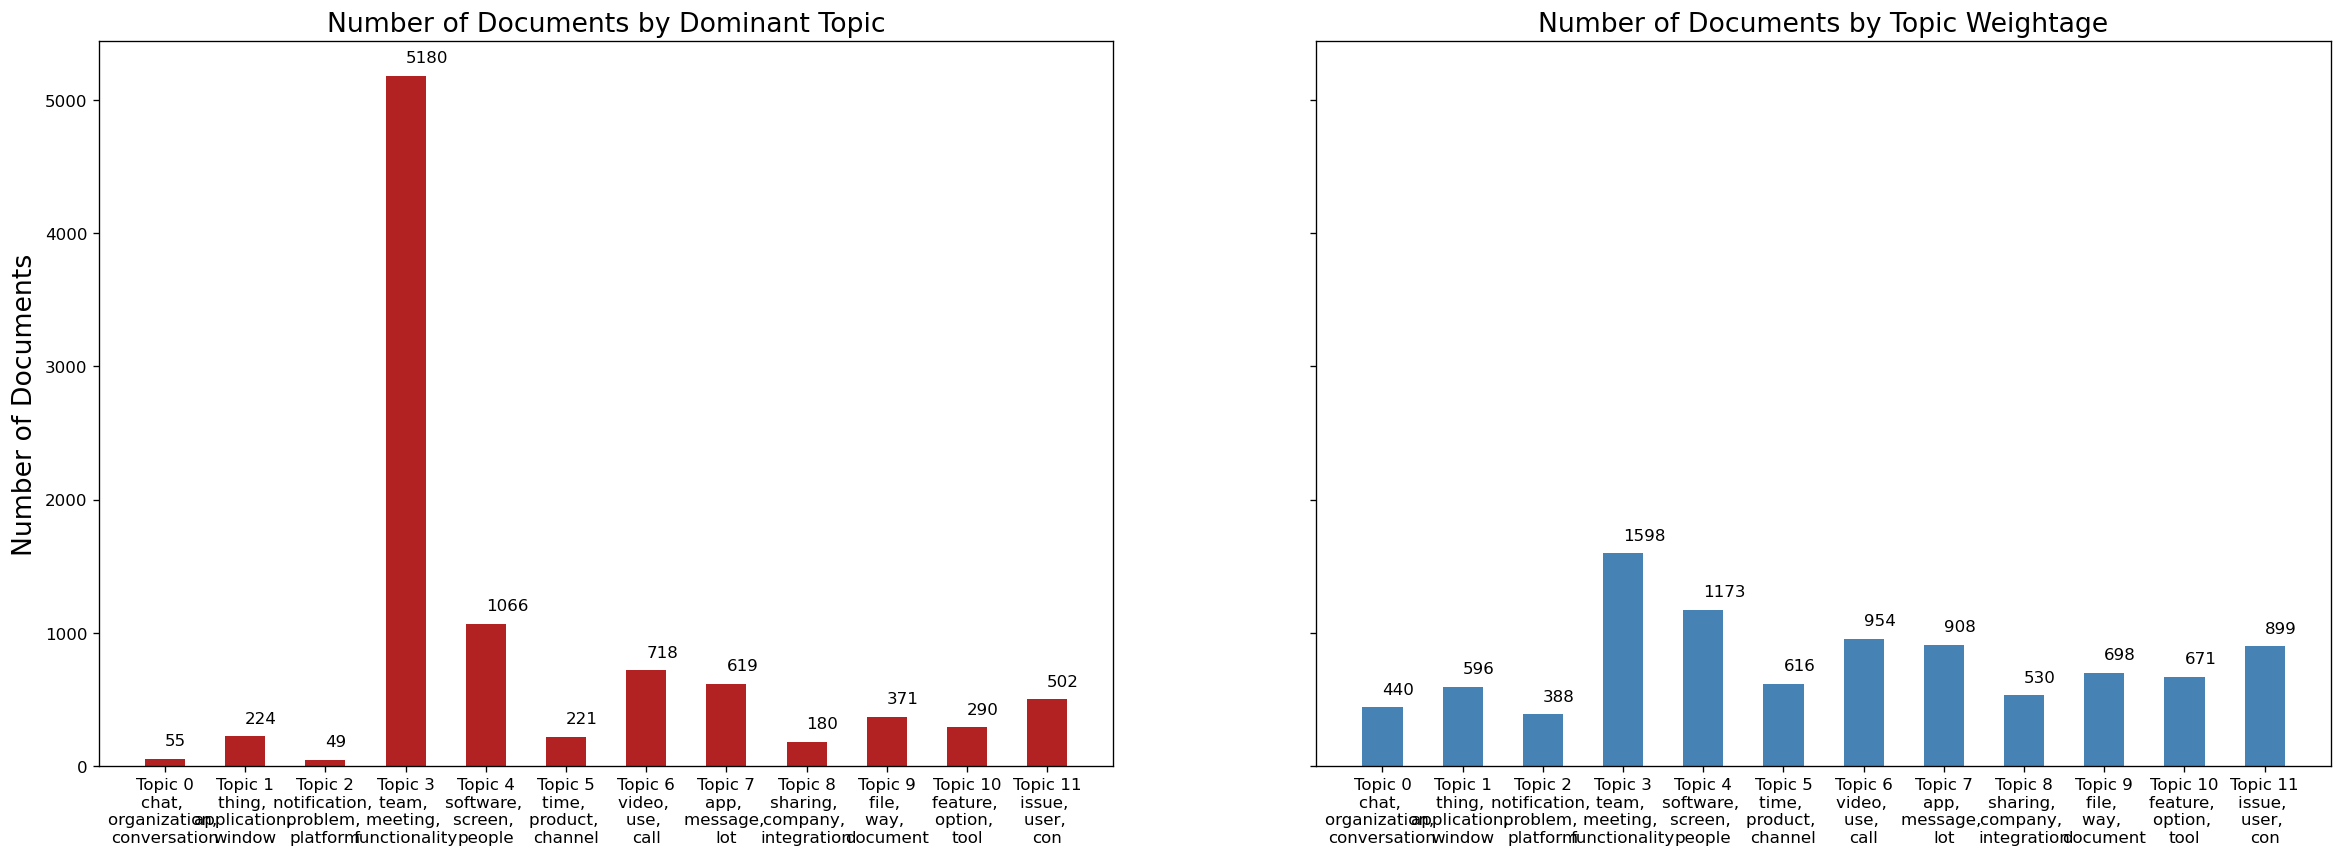

In [17]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
for index,data in enumerate(df_dominant_topic_in_each_doc['count']):
    ax1.text(x=index , y =data+100 , s=int(data) , fontdict=dict(fontsize=10))
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, _: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=16))
ax1.set_ylabel('Number of Documents', fontdict=dict(size=16))

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
for index,data in enumerate(df_topic_weightage_by_doc['count']):
    ax2.text(x=index , y =data+100 , s=int(data) , fontdict=dict(fontsize=10))
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=16))

plt.savefig('Documents_teams_cons.png')
plt.show()

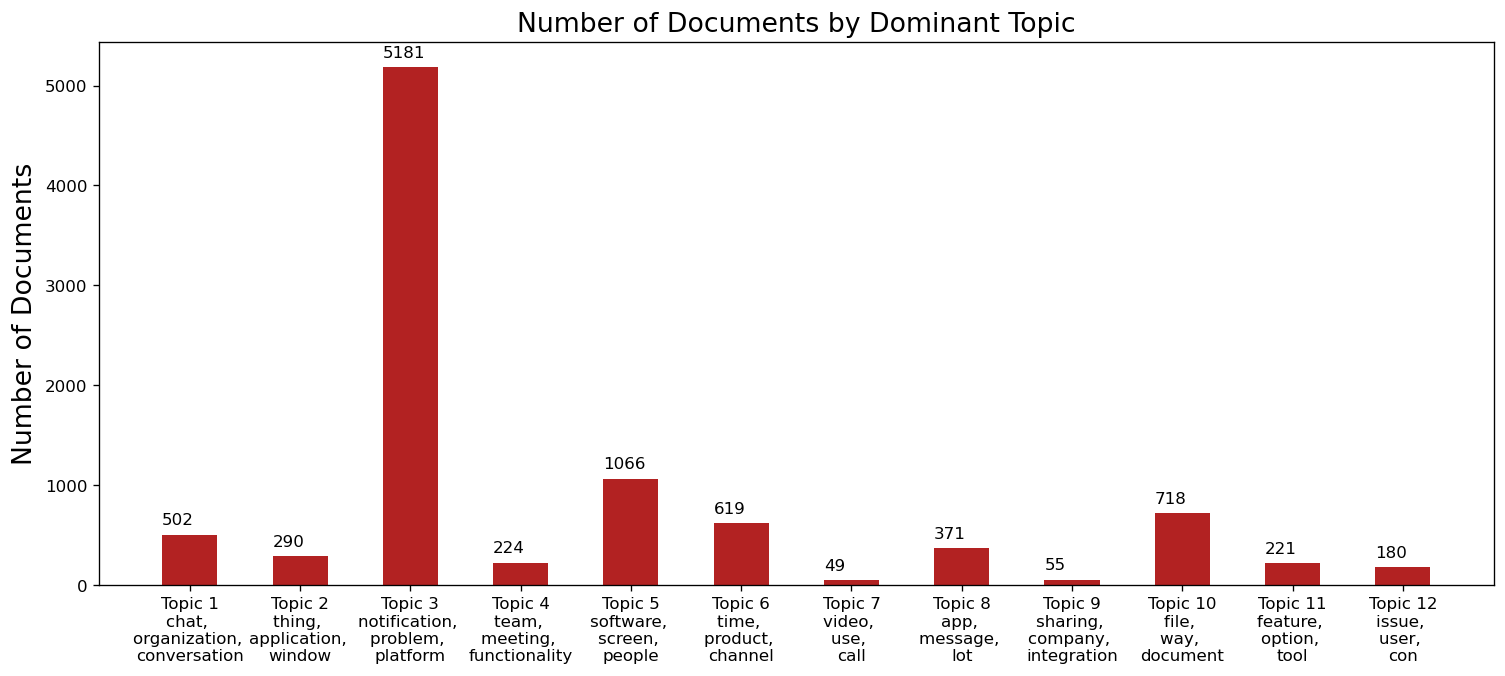

In [19]:
import numpy as np
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
from matplotlib.ticker import FuncFormatter
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()


# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)
# topic_contribution = topic_contribution.rename_axis('Dominant_Topic').reset_index(name='percentage')

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']].drop_duplicates()
topic_num_keywords.index = range(len(topic_num_keywords))

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_contribution, topic_counts], axis=1)
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Perc_eviews', 'Num_Reviews']
df_dominant_topics = df_dominant_topics.sort_values(by=['Dominant_Topic'])


# Plot
fig, ax1 = plt.subplots(1, 1, figsize=(15, 6), dpi=120, sharey=True)
# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='Num_Reviews', data=df_dominant_topics, width=.5, color='firebrick')
for index,data in enumerate(df_dominant_topics['Num_Reviews']):
    ax1.text(x=index-0.25 , y =data+100 , s=int(data) , fontdict=dict(fontsize=10))
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, _: 'Topic ' + str(x+1)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=16))
ax1.set_ylabel('Number of Documents', fontdict=dict(size=16))
plt.savefig('Documents_teams_cons.png')
plt.show()

### LDA 法二

In [129]:
from gensim.models import LdaMulticore
# Build LDA model
import matplotlib.pyplot as plt
topics_num = []
Coherence_Score = []

for i in range(1,21):
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=i, 
                                            random_state=100,
                                            chunksize=100,
                                            passes=10,
                                            per_word_topics=True)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    topics_num.append(i)
    Coherence_Score.append(coherence_lda)

C:\Users\lindy\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\lindy\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


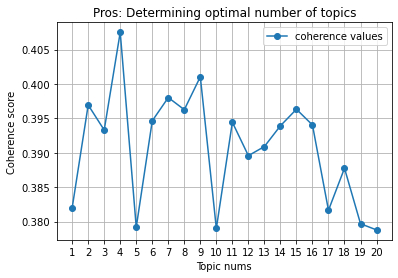

In [34]:
lines = plt.plot(topics_num, Coherence_Score)
plt.setp(lines, marker = "o") 
plt.grid(True)
plt.title("Pros: Determining optimal number of topics") 
plt.xlabel("Topic nums")
plt.ylabel("Coherence score")
plt.legend(["coherence values"], loc='best')
plt.xticks(topics_num)
plt.show()

In [93]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

C:\Users\lindy\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [95]:
import numpy as np
import tqdm
grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')
# Validation sets
num_of_docs = len(corpus)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=540)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()

C:\Users\lindy\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)

  0%|                                                                                          | 0/540 [30:25<?, ?it/s]

 24%|██████████████████▍                                                           | 128/540 [30:52<1:40:52, 14.69s/it]


 48%|████████████████████████████████████▌                                       | 260/540 [1:01:52<1:05:27, 14.03s/it]


 73%|████████████████████████████████████████████████████████▌                     | 392/540 [1:33:48<35:07, 14.24s/it]


 97%|███████████████████████████████████████████████████████████████████████████▋  | 524/540 [2:06:20<03:59, 14.98s/it]


100%|██████████████████████████████████████████████████████████████████████████████| 540/540 [2:10:13<00:00, 14.47s/it]


In [35]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=9, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.91,
                                           eta=0.91)

C:\Users\lindy\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [36]:
from pprint import pprint
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.004*"zoom" + 0.004*"host" + 0.003*"easy" + 0.003*"meeting" + '
  '0.003*"group" + 0.003*"feature" + 0.003*"use" + 0.002*"reaction" + '
  '0.002*"allow" + 0.002*"chat"'),
 (1,
  '0.004*"zoom" + 0.003*"easy" + 0.002*"meeting" + 0.001*"video" + 0.001*"use" '
  '+ 0.001*"feature" + 0.001*"work" + 0.001*"software" + 0.001*"user" + '
  '0.001*"great"'),
 (2,
  '0.008*"student" + 0.006*"zoom" + 0.006*"teacher" + 0.004*"class" + '
  '0.004*"software" + 0.003*"face" + 0.003*"teach" + 0.003*"learn" + '
  '0.002*"use" + 0.002*"school"'),
 (3,
  '0.036*"zoom" + 0.034*"meeting" + 0.020*"easy" + 0.017*"feature" + '
  '0.016*"video" + 0.013*"screen" + 0.012*"share" + 0.011*"also" + '
  '0.011*"software" + 0.011*"use"'),
 (4,
  '0.003*"zoom" + 0.003*"easy" + 0.002*"meeting" + 0.001*"video" + '
  '0.001*"feature" + 0.001*"software" + 0.001*"work" + 0.001*"great" + '
  '0.001*"use" + 0.001*"screen"'),
 (5,
  '0.004*"meeting" + 0.003*"zoom" + 0.003*"easy" + 0.002*"keep" + '
  '0.002*"opportunit

C:\Users\lindy\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [37]:
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

C:\Users\lindy\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Coherence Score:  0.36378294852872695


In [114]:
# !pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

C:\Users\lindy\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.183433  0.000548       1        1  71.340992
8     -0.008453 -0.013816       2        1   5.298651
2      0.013261  0.016711       3        1   4.206442
0      0.011204  0.002529       4        1   3.436912
5      0.031109 -0.001798       5        1   3.398365
6      0.018849  0.002244       6        1   3.342570
7      0.041380 -0.002129       7        1   3.055659
1      0.035391 -0.001912       8        1   2.963721
4      0.040692 -0.002378       9        1   2.956688, topic_info=         Term        Freq       Total Category  logprob  loglift
43       zoom  905.000000  905.000000  Default  30.0000  30.0000
421   student   63.000000   63.000000  Default  29.0000  29.0000
125      host  101.000000  101.000000  Default  28.0000  28.0000
5        easy  509.000000  509.000000  Default  27.0000  27.0000
33   software  277.000000  277.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
99       time    0.705888  181.507761   Topic9  -7.2359  -2.0285
57        get    0.659232  104.938645   Topic9  -7.3043  -1.5490
411      need    0.674715  137.151131   Topic9  -7.2811  -1.7934
186      even    0.660484  147.856703   Topic9  -7.3024  -1.8899
2        chat    0.659307  176.704901   Topic9  -7.3042  -2.0699

[597 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
233       1  0.945155  able
233       2  0.008833  able
233       3  0.008833  able
233       4  0.008833  able
233       5  0.008833  able
...     ...       ...   ...
43        5  0.004415  zoom
43        6  0.007727  zoom
43        7  0.003311  zoom
43        8  0.004415  zoom
43        9  0.003311  zoom

[1249 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 9, 3, 1, 6, 7, 8, 2, 5])